In [1]:
!pip install quandl

In [3]:
!pip install xgboost

In [58]:
import pandas as pd
import quandl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
import math, datetime

style.use('ggplot')

In [59]:
api_key = "TJSRKk9F8rPayqKtk-PJ"
quandl.ApiConfig.api_key = api_key

In [60]:
df = quandl.get("BITFINEX/BTCUSD")

In [61]:
df

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.0000,503.5000,504.97,21013.584774
2014-04-16,547.0000,495.00,537.50000,538.0000,537.0000,538.00,29633.358705
2014-04-17,538.5000,486.10,507.02000,508.0000,506.0400,508.00,20709.783819
2014-04-18,509.0000,474.25,483.77000,482.7500,482.7500,484.79,10458.045243
2014-04-19,513.9899,473.83,505.01065,507.4999,502.5313,507.49,8963.618369
...,...,...,...,...,...,...,...
2021-04-29,55222.0000,52377.00,53342.50000,53334.0000,53340.0000,53345.00,7050.927371
2021-04-30,57342.0000,53068.00,57072.00000,57076.0000,57067.0000,57077.00,7338.388758
2021-05-01,58326.0000,57000.00,57564.50000,57564.0000,57564.0000,57565.00,4821.773340


In [62]:
df.dropna(inplace = True)
df.isnull().sum()

High      0
Low       0
Mid       0
Last      0
Bid       0
Ask       0
Volume    0
dtype: int64

In [63]:
df["HL_PCT"] = (df["High"] - df["Low"]) / df["Last"] * 100.0
df["ASKBID_PCT"] = (df["Ask"] - df["Low"]) / df["Ask"] * 100.0

In [64]:
df.head()

,High,Low,Mid,Last,Bid,Ask,Volume,HL_PCT,ASKBID_PCT
Date,,,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.0000,503.5000,504.97,21013.584774,12.257426,10.489732
2014-04-16,547.0000,495.00,537.50000,538.0000,537.0000,538.00,29633.358705,9.665428,7.992565
2014-04-17,538.5000,486.10,507.02000,508.0000,506.0400,508.00,20709.783819,10.314961,4.311024
2014-04-18,509.0000,474.25,483.77000,482.7500,482.7500,484.79,10458.045243,7.198343,2.174137
2014-04-19,513.9899,473.83,505.01065,507.4999,502.5313,507.49,8963.618369,7.913282,6.632643


In [65]:
df.drop(["Mid","Bid","Ask"], axis = 1, inplace = True)

In [66]:
df.head()

,High,Low,Last,Volume,HL_PCT,ASKBID_PCT
Date,,,,,,
2014-04-15,513.9000,452.00,505.0000,21013.584774,12.257426,10.489732
2014-04-16,547.0000,495.00,538.0000,29633.358705,9.665428,7.992565
2014-04-17,538.5000,486.10,508.0000,20709.783819,10.314961,4.311024
2014-04-18,509.0000,474.25,482.7500,10458.045243,7.198343,2.174137
2014-04-19,513.9899,473.83,507.4999,8963.618369,7.913282,6.632643


In [86]:
forecast_out = int(math.ceil(len(df)* 0.01))

In [68]:
df["Label"] = df["Last"].shift(-forecast_out)

In [69]:
df.isnull().sum()

High           0
Low            0
Last           0
Volume         0
HL_PCT         0
ASKBID_PCT     0
Label         26
dtype: int64

In [70]:
X = df.drop(['Label'], axis = 1)

In [71]:
y = df.iloc[:,-1]

In [72]:
X_toPredict = X[-forecast_out:]
X = X[:-forecast_out]
y = y[:-forecast_out]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [104]:
from xgboost import XGBRegressor
lr = XGBRegressor().fit(X_train,y_train)
Accuracy = lr.score(X_test, y_test)
print(Accuracy)

0.9553390138713264


C:\Users\Onur\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [105]:
prediction_set = lr.predict(X_toPredict)

C:\Users\Onur\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [106]:
df['Prediction'] = np.nan

In [107]:
last_date = df.iloc[-1].name
lastDatetime = last_date.timestamp()
one_day = 86400
nextDatetime = lastDatetime + one_day

In [108]:
for i in prediction_set:
    next_day = datetime.datetime.fromtimestamp(nextDatetime)
    nextDatetime += one_day
    df.loc[next_day] = [np.nan for q in range(len(df.columns) -1)] + [i]

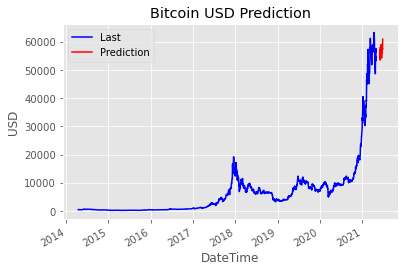

In [117]:
df['Last'].plot(color = 'b')
df['Prediction'].plot(color = 'r')
plt.title('Bitcoin USD Prediction')
plt.xlabel('DateTime')
plt.ylabel('USD')
plt.legend()
plt.show()

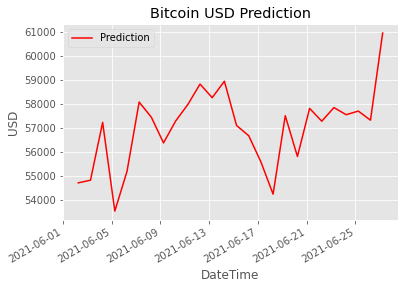

In [118]:
df['Prediction'].plot(color = 'r')
plt.title('Bitcoin USD Prediction')
plt.xlabel('DateTime')
plt.ylabel('USD')
plt.legend()
plt.show()